In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error,mean_squared_error

##### load data

In [2]:
with open("./data/zhengqi_train.txt")  as file:
    train=pd.read_table(file, sep="\t")
with open("./data/zhengqi_test.txt") as file:
    test=pd.read_table(file, sep="\t")

In [3]:
train.shape

(2888, 39)

In [4]:
test.shape

(1925, 38)

##### Exploratory data analysis

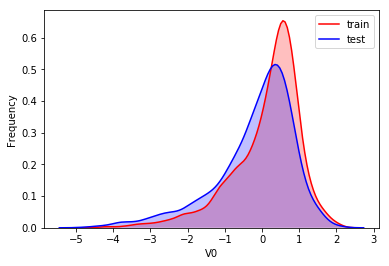

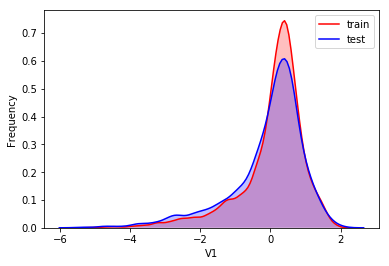

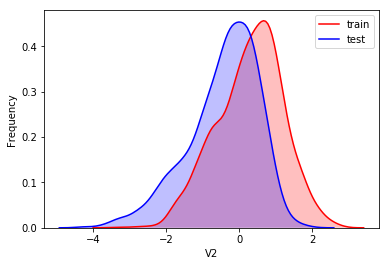

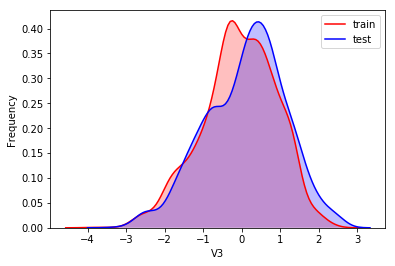

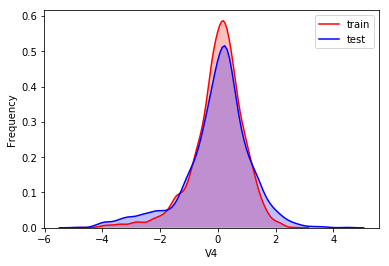

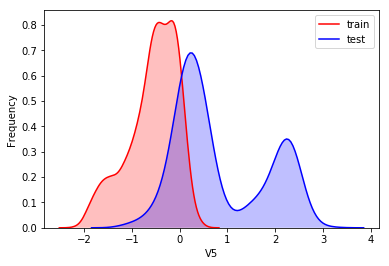

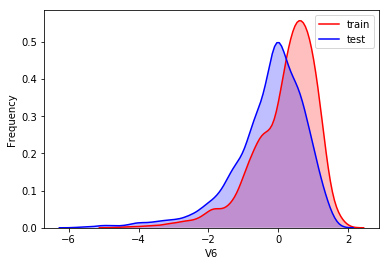

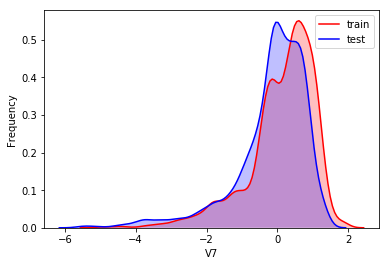

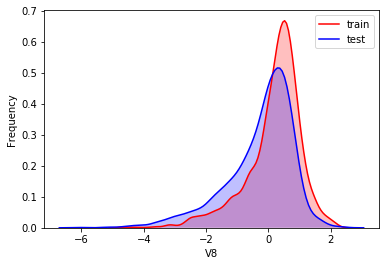

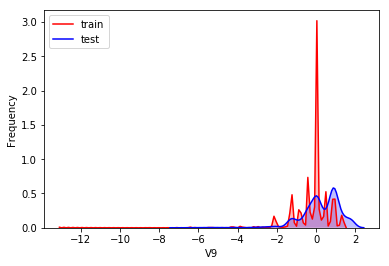

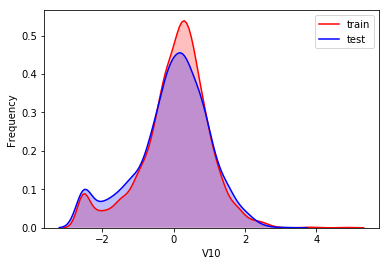

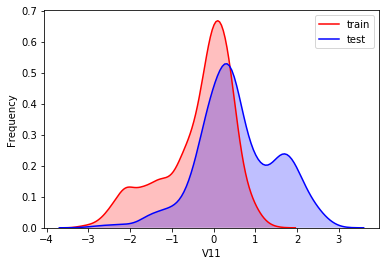

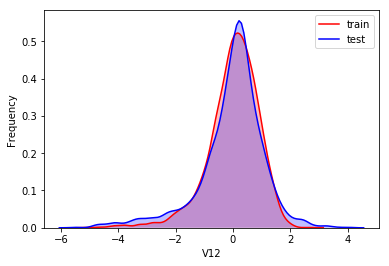

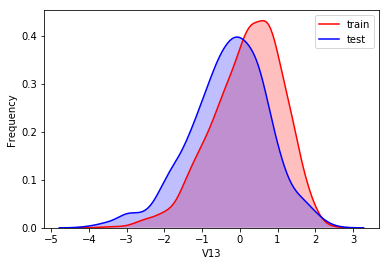

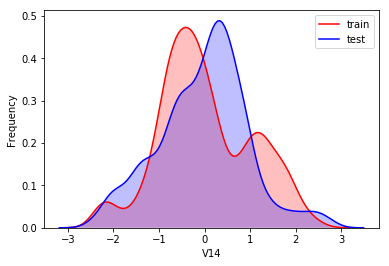

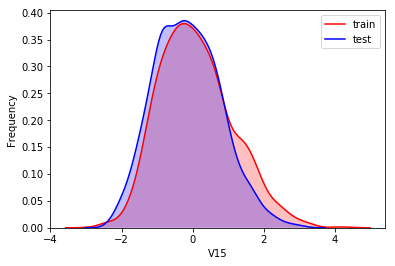

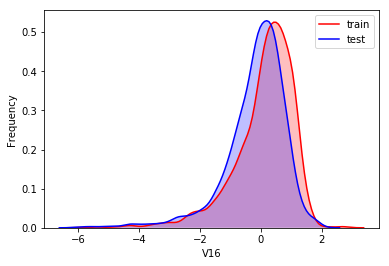

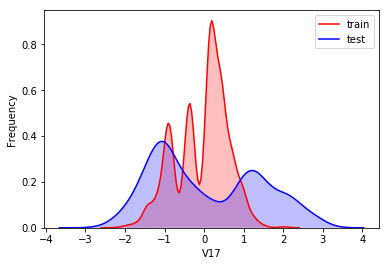

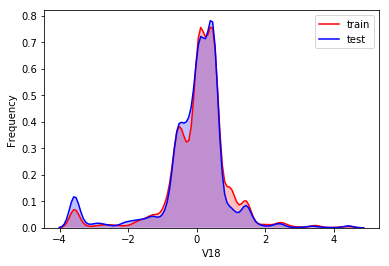

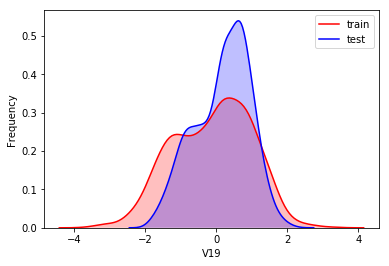

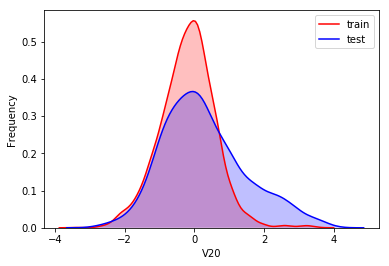

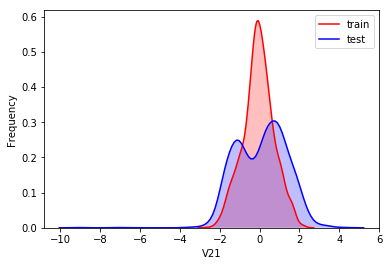

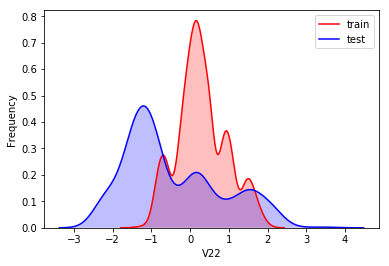

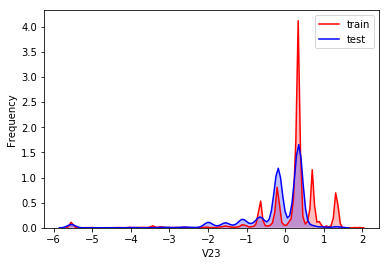

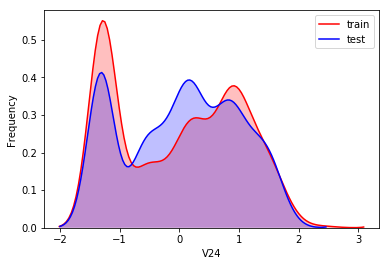

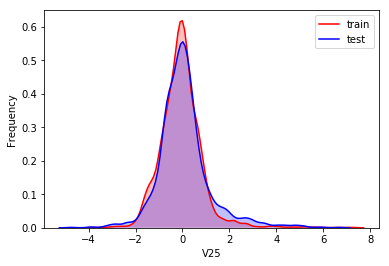

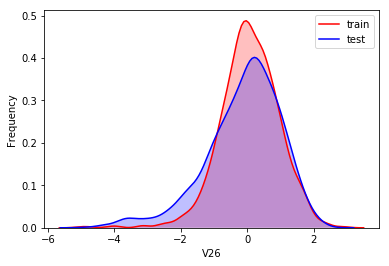

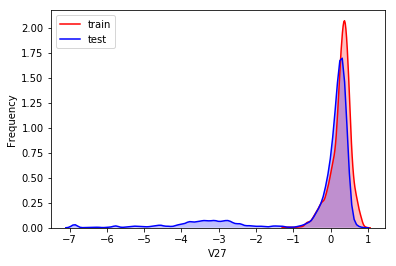

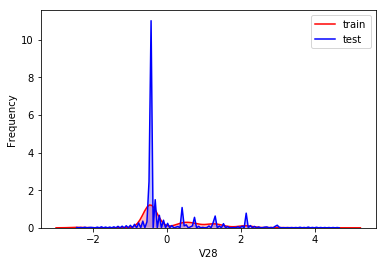

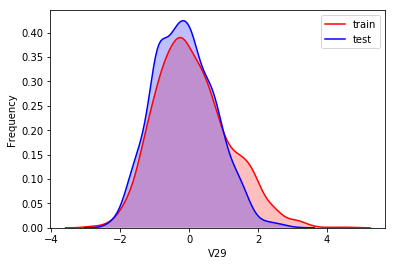

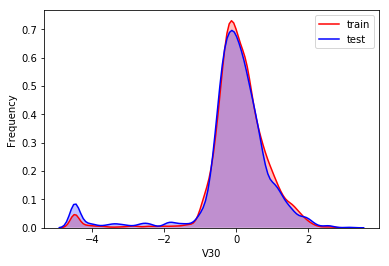

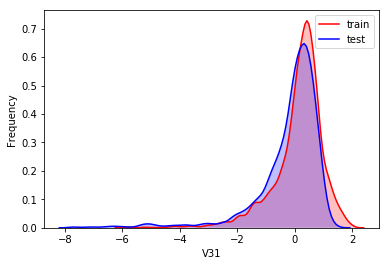

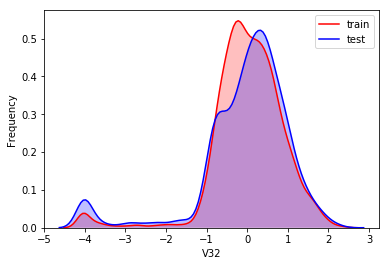

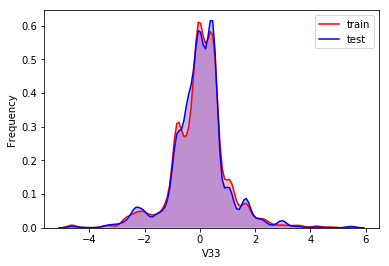

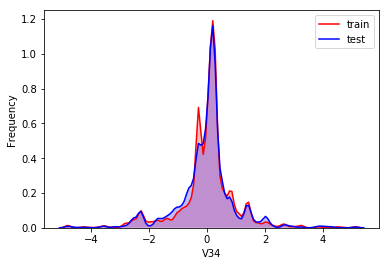

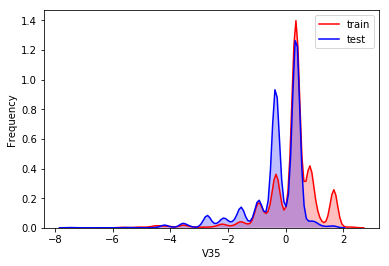

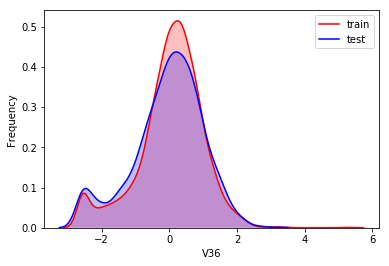

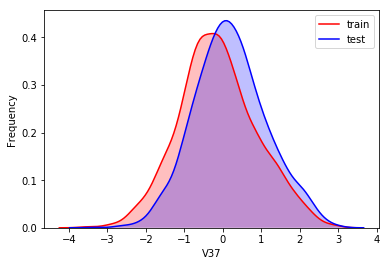

In [8]:
for column in test.columns:
    g = sns.kdeplot(train[column], color="Red", shade = True)
    g = sns.kdeplot(test[column], ax =g, color="Blue", shade= True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train","test"])
    plt.show()

In [5]:
# drop features in different distributions
target = train.target
train.drop(["target"], axis=1, inplace=True)
train.drop(["V5","V9","V11","V17","V22","V28"], axis=1, inplace=True)
test.drop(["V5","V9","V11","V17","V22","V28"], axis=1, inplace=True)

In [6]:
train.shape

(2888, 32)

In [7]:
target.shape

(2888,)

##### LGBMRegressor  paremeter grid search

In [100]:
params_test1={'min_child_samples':np.arange(5,100,5)
              'colsample_bytree': np.arange(0.3, 1, 0.05)
              'n_estimators': np.arange(40, 300, 10)
             }
model = lgb.LGBMRegressor(  objective='regression',
                            metric='neg_mean_squared_error', 
                            categorical_feature =categorical_col
                            learning_rate=0.1, 
                            num_leaves=55,
                            reg_alpha=0.6,
                            reg_lambda=4.3,
                            subsample=0.7,
                            subsample_freq=2,
                            random_state=42,
                            reg_alpha=0.3, 
                            reg_lambda=0.08 )
gsearch = GridSearchCV(estimator=model, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
gsearch.fit(train, target)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    7.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       metric='neg_mean_squared_error', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=75,
       n_jobs=-1, num_leaves=55, objective='regression', random_state=42,
       reg_alpha=0.0, reg_lambda=4.3, silent=True, subsample=0.7,
       subsample_for_bin=200000, subsample_freq=2),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_child_samples': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

##### Plot mean test scores in gsearch

In [102]:
score = gsearch.cv_results_["mean_test_score"]

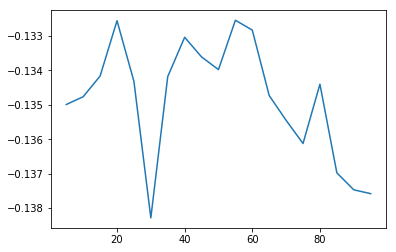

In [103]:
plt.plot(np.arange(5,100,5),
        score)

##### plot mean test score in 3-D view when searching parameters twice at atime

In [30]:
import h5py
file = h5py.File("./data/score_colsample.h5", "w")
file["score"] = score

In [40]:
file.close()

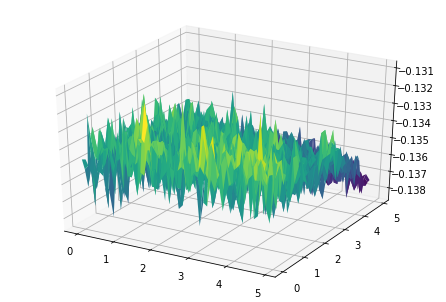

In [10]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(0, 5, 0.1)
y = np.arange(0, 5, 0.1)
X, Y = np.meshgrid(x, y)
Z = gsearch.cv_results_["mean_test_score"].reshape((len(y), len(x)))
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)
plt.show()

#####  Fit and prediction using best_parameters

In [8]:
model_bst = lgb.LGBMRegressor(objective='regression',
                            metric='neg_mean_squared_error', 
                          learning_rate=0.1, 
                            n_estimators=75,
                            num_leaves=55,
                            reg_alpha=0.6,
                            reg_lambda=4.3,
                            min_child_samples=20,
                            colsample_bytree =0.7,
                            subsample=0.7,
                            subsample_freq=2,
                            random_state=42
                              )

In [9]:
model_bst.fit(train, target)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       metric='neg_mean_squared_error', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=75,
       n_jobs=-1, num_leaves=55, objective='regression', random_state=42,
       reg_alpha=0.6, reg_lambda=4.3, silent=True, subsample=0.7,
       subsample_for_bin=200000, subsample_freq=2)

#####  save predict results

In [10]:
pred_test = model_bst.predict(test)

In [12]:
with open("./data/results/best_para.txt", "w", encoding='utf8') as file:
    for i in pred_test:
        file.write(str(i)+"\n")
    file.close()

##### 5KFold fit and predict for stacking

In [12]:
model = lgb.LGBMRegressor( learning_rate=0.05, 
                            n_estimators=1000,
                            num_leaves=31,
                            reg_alpha=2,
                            reg_lambda=2,
                            min_child_samples=20,
                            colsample_bytree =0.7,
                            subsample=0.7,
                            subsample_freq=2,
                            random_state=42)

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
result_val = np.zeros(shape=(len(train),))
result_test = np.zeros(shape=(len(test),))
for i, (tr_index, val_index) in enumerate(kf.split(train, label)):
    tr_X, val_X = train.iloc[tr_index,:], train.iloc[val_index,:]
    tr_y, val_y = label[tr_index], label[val_index]
    
    model.fit(X=tr_X, y=tr_y, eval_set=[(val_X, val_y)], eval_metric="mse", early_stopping_rounds=5, verbose=10)

    pred_val_y = model.predict(val_X)
    mse = mean_squared_error(y_pred=pred_val_y, y_true=val_y)
    print("mse:", mse)
    result_val[val_index] = pred_val_y
    pred_test = model.predict(test)
    result_test += pred_test
    break
result_test /=5

Training until validation scores don't improve for 5 rounds.
[10]	valid_0's l2: 0.474309	valid_0's l2: 0.474309
[20]	valid_0's l2: 0.273695	valid_0's l2: 0.273695
[30]	valid_0's l2: 0.190505	valid_0's l2: 0.190505
[40]	valid_0's l2: 0.152674	valid_0's l2: 0.152674
[50]	valid_0's l2: 0.135686	valid_0's l2: 0.135686
[60]	valid_0's l2: 0.125739	valid_0's l2: 0.125739
[70]	valid_0's l2: 0.119594	valid_0's l2: 0.119594
[80]	valid_0's l2: 0.1166	valid_0's l2: 0.1166
[90]	valid_0's l2: 0.113911	valid_0's l2: 0.113911
[100]	valid_0's l2: 0.112342	valid_0's l2: 0.112342
[110]	valid_0's l2: 0.110266	valid_0's l2: 0.110266
[120]	valid_0's l2: 0.108986	valid_0's l2: 0.108986
[130]	valid_0's l2: 0.108251	valid_0's l2: 0.108251
[140]	valid_0's l2: 0.107774	valid_0's l2: 0.107774
Early stopping, best iteration is:
[143]	valid_0's l2: 0.107655	valid_0's l2: 0.107655
mse: 0.10765532384190639
Training until validation scores don't improve for 5 rounds.
[10]	valid_0's l2: 0.482089	valid_0's l2: 0.482089


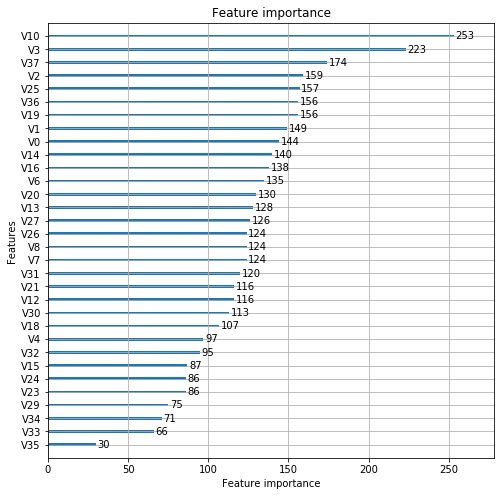

In [110]:
lgb.plot_importance(model, figsize=(8,8))